In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches
import numpy as np

import optax
import matplotlib.pyplot as plt

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT, apply_Jacobi
from loss import LLT_loss
from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT
from utils import params_count

# Make dataset

In [3]:
grid = 16
N_samples = 30

In [4]:
A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train = dataset_LLT(grid, N_samples, seed=42)
A_test, b_test, u_exact_test, bi_edges_test, nodes_test, edges_test, receivers_test, senders_test = dataset_LLT(grid, N_samples=10, seed=43)

2024-03-20 11:42:51.467500: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# Normalize linear system in form: norm**(-1) * A @ u = f * norm**(-1)

norm_train = jnp.linalg.norm(edges_train, axis=1)
norm_test = jnp.linalg.norm(edges_test, axis=1)

edges_train = jnp.einsum('bi, b -> bi', edges_train, 1./norm_train)
nodes_train = jnp.einsum('bi, b -> bi', nodes_train, 1./norm_train)
b_train = jnp.einsum('bi, b -> bi', b_train, 1./norm_train)
A_train = A_train / norm_train[..., None, None]

edges_test = jnp.einsum('bi, b -> bi', edges_test, 1./norm_test)
nodes_test = jnp.einsum('bi, b -> bi', nodes_test, 1./norm_test)
b_test = jnp.einsum('bi, b -> bi', b_test, 1./norm_test)
A_test = A_test / norm_test[..., None, None]

# Train model

In [6]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 3009


In [7]:
# L_before_train = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)[0, ...].todense()
# print(f'Minimum element in initial L: {jnp.abs(L_before_train).min().item():.5f}, maximum element in initial L: {jnp.abs(L_before_train).max().item():.5f}')
# print(f'Initial loss value: {LLT_loss(L_before_train, u_exact_train[0, ...], b_train[0, ...]).item(): .5f}')
# plt.imshow(L_before_train, vmin=A_train.data.min().item(), vmax=A_train.data.max().item());

In [8]:
lr = 1e-3
# start, stop, step = 40, 101, 40
# decay_size = .5
# lr = optax.piecewise_constant_schedule(
#     lr,
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

In [9]:
X_train = (nodes_train, edges_train, receivers_train, senders_train, bi_edges_train, u_exact_train, b_train, A_train)
X_test = (nodes_test, edges_test, receivers_test, senders_test, bi_edges_test, u_exact_test, b_test, A_test)
data = (X_train, X_test, jnp.array([1]), jnp.array([1]))

train_config = {'optimizer': optax.adam,
                'lr': lr,
                'optim_params': {},#{'weight_decay': 1e-8}, 
                'epoch_num': 100}
model, losses = train(model, data, train_config, compute_loss_LLT)

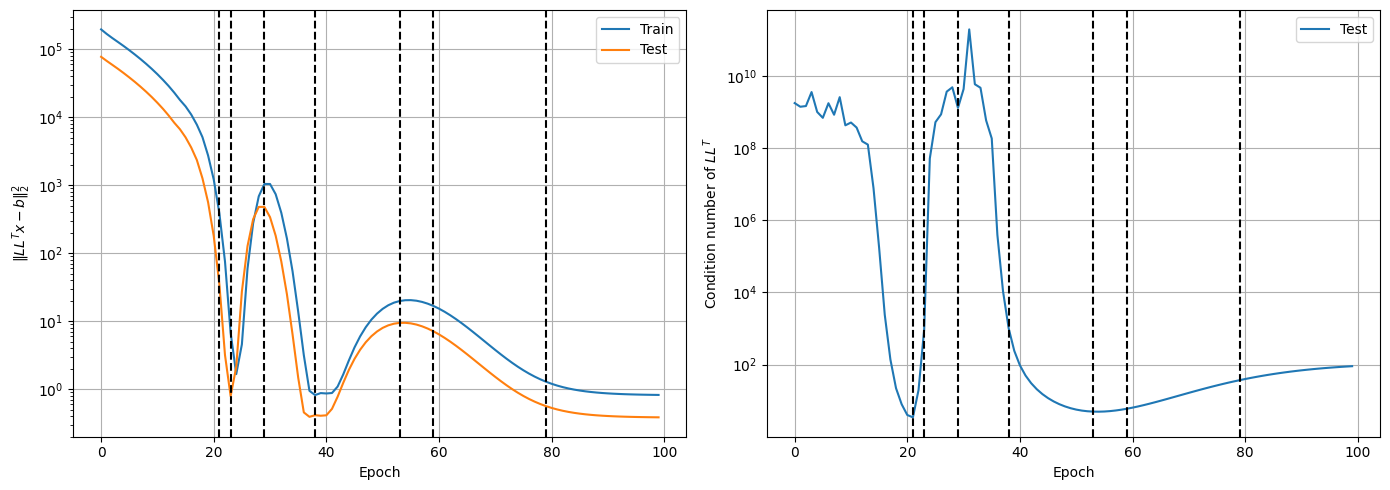

In [30]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('$\|LL^Tx - b\|_2^2$');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Condition number of $LL^T$')
axes[1].grid();

for vl in [21, 23, 29, 38, 53, 59, 79]:
    axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
    axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')

plt.tight_layout()

In [11]:
print(f'Final values\n  train loss: {losses[0][-1]:.5f}\n   test loss: {losses[1][-1]:.5f}\n    LLT cond: {losses[2][-1]:.2f}')

Final values
  train loss: 0.82298
   test loss: 0.38556
    LLT cond: 90.63


# Check preconditioner

In [12]:
del X_train, A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train

In [13]:
# L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)[0, ...].todense()

In [14]:
# print("Max and min of A's diagonal")
# round(A_train.todense()[0, ...].diagonal().min().item(), 5), round(A_train.todense()[0, ...].diagonal().max().item(), 5)

In [15]:
# print("Max and min of LL^T's diagonal")
# round((L @ L.T).diagonal().min().item(), 5), round((L @ L.T).diagonal().max().item(), 5)

In [16]:
# print(f'Minimum change in diagonal: {jnp.abs((L @ L.T).diagonal() - A_train.todense()[0, ...].diagonal()).min().item():.6f}')
# print(f'Maximum change in diagonal: {jnp.abs((L @ L.T).diagonal() - A_train.todense()[0, ...].diagonal()).max().item():.6f}')
# plt.hist((L @ L.T).diagonal() - A_train.todense()[0, ...].diagonal(), bins=20)
# plt.title('Histogram of diagonal of "A - LL^T"');

In [17]:
# print(f'Condition number of A:      {jnp.linalg.cond(A_train.todense()[0, ...]):.2f}')
# print(f'Condition number of L:      {jnp.linalg.cond(L):.2f}')
# print(f'Condition number of LL^T:   {jnp.linalg.cond(L @ L.T):.2f}')
# print(f'Condition number of Jacobi: {jnp.linalg.cond(jnp.diag(jnp.diag(A_train.todense()[0, ...]))):.2f}')

In [18]:
# jnp.square(jnp.linalg.norm(A_train.todense()[0, ...] - L @ L.T, ord='fro')).item()

In [19]:
# print(f'Minimum element in trained L: {jnp.abs(L).min().item():.5f}\nMaximum element in trained L: {jnp.abs(L).max().item():.5f}')
# print(f'Final train loss value:       {LLT_loss(L, u_exact_train[0, ...], b_train[0, ...]).item():.5f}', end='\n\n')
# a_llt = jnp.square(jnp.linalg.norm(A_train.todense()[0, ...] - L @ L.T, ord='fro')).item()
# print(f'Squared Frobenius norm of "A-LL^T": {a_llt:.5f}')

In [20]:
# plt.hist((L_before_train - L)[senders_train[0, ...], receivers_train[0, ...]], bins=20)
# plt.title('Histogram of difference in L elements from random initialization and trained model');

In [21]:
# plt.hist(L[senders_train[0, ...], receivers_train[0, ...]], bins=20)
# plt.title('Histogram of nonzero elements in trained L');

# Apply model to CG

In [22]:
# Data for CG

# data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
data_cg_test = (A_test, b_test, u_exact_test, nodes_test, edges_test, receivers_test, senders_test, bi_edges_test)

In [23]:
# Not preconditioned

# X_I, R_I, _ = ConjGrad(data_cg_train, N_iter=300, model=None, prec_func=None, m_max=None, seed=42)
X_I, R_I, _ = ConjGrad(data_cg_test, N_iter=300, model=None, prec_func=None, m_max=None, seed=42)

In [24]:
# Apply LLT model
prec = vmap(apply_LLT, in_axes=(None, 0, 0, 0, 0, 0, 0, 0), out_axes=(0))

# X_LLT, R_LLT, _ = ConjGrad(data_cg_train, N_iter=100, model=model, prec_func=apply_LLT, m_max=None, seed=42)
X_LLT, R_LLT, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=prec, m_max=None, seed=42)

In [25]:
# Apply Jacobi prec model

# X_J, R_J, _ = ConjGrad(data_cg_train, N_iter=300, model=model, prec_func=apply_Jacobi, m_max=None, seed=42)
# X_J, R_J, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=apply_Jacobi, m_max=None, seed=42)

CG NO prec. Iter when reach 10e-12: 74
CG with prec. Iter when reach 10e-12: 29


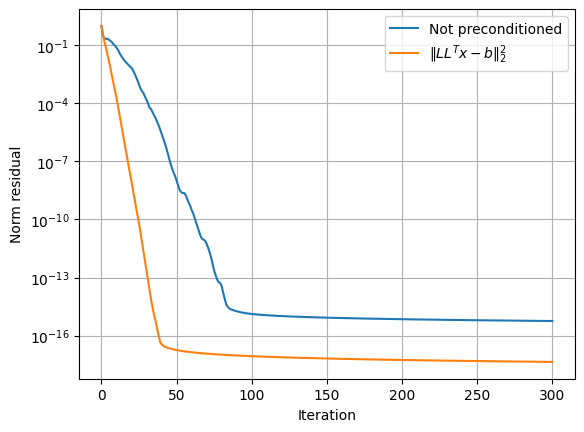

In [26]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")
# plt.plot(range(R_J.shape[-1]), jnp.linalg.norm(R_J, axis=1).mean(0), label="Jacobi")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();
# plt.ylim([1e-15, 1e0]);

print('CG NO prec. Iter when reach 10e-12:', jnp.where(jnp.linalg.norm(R_I, axis=1).mean(0) <= 1e-12)[0][0].item())
print('CG with prec. Iter when reach 10e-12:', jnp.where(jnp.linalg.norm(R_LLT, axis=1).mean(0) <= 1e-12)[0][0].item())

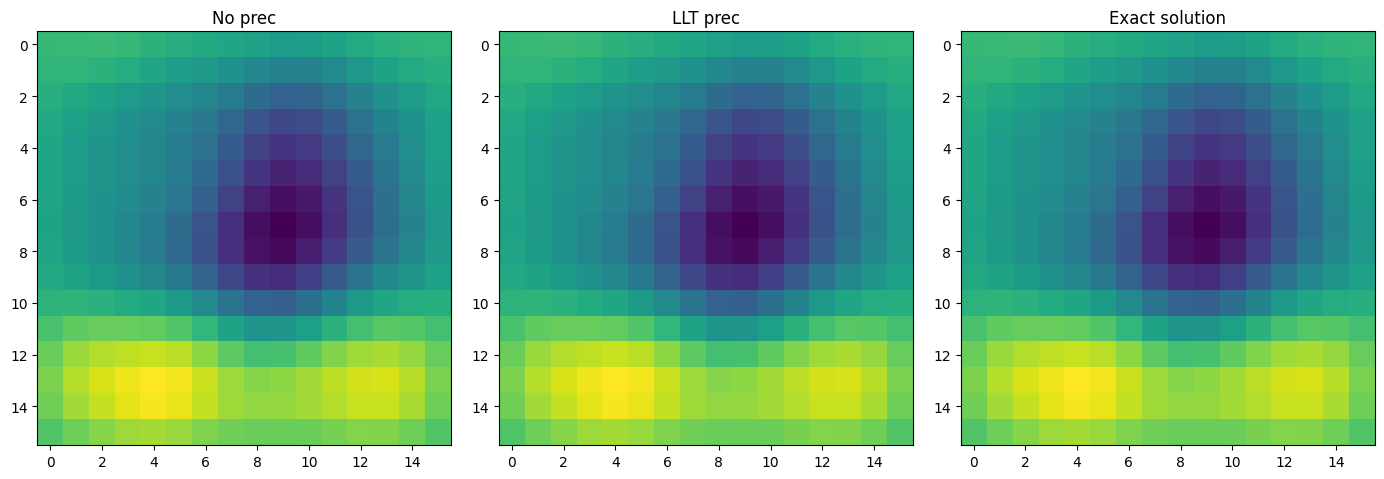

In [27]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT prec')
axes[2].set_title('Exact solution')

plt.tight_layout()

In [28]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# ax.imshow(jnp.linalg.inv(A_test.todense())[0, ...])
# ax.axis(False);